In [1]:
# --------------------------------------------------
# 0. Imports & basic setup
# --------------------------------------------------
import os
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Paths – adjust if your folder is somewhere else
DATA_DIR   = "../DATA/RealWaste"   # contains Cardboard/, Glass/, etc.
OUTPUT_DIR = "../OUTPUT"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE   = (224, 224)  # a bit smaller than 224 to speed things up
BATCH_SIZE = 32
EPOCHS     = 15
SEED       = 42


In [9]:
# --------------------------------------------------
# 1. Map fine-grained labels → 3 super-classes
# --------------------------------------------------
FINE_TO_COARSE = {
    "Cardboard"        : "Recyclable",
    "Glass"            : "Recyclable",
    "Metal"            : "Recyclable",
    "Paper"            : "Recyclable",
    "Plastic"          : "Recyclable",
    "Food Organics"    : "Compostable",
    "Vegetation"       : "Compostable",
    "Miscellaneous Trash": "Trash",
    "Textile Trash"    : "Trash",
}

COARSE_CLASSES = ["Recyclable", "Compostable", "Trash"]
COARSE_TO_IDX  = {c: i for i, c in enumerate(COARSE_CLASSES)}

In [11]:
# --------------------------------------------------
# 2. Scan folders → list of image paths + 3-class labels
# --------------------------------------------------
def list_files_and_labels(base_dir):
    paths = []
    labels = []
    for fine_label in os.listdir(base_dir):
        fine_path = os.path.join(base_dir, fine_label)
        if not os.path.isdir(fine_path):
            continue
        if fine_label not in FINE_TO_COARSE:
            # Ignore unexpected folders
            print(f"Skipping unknown folder: {fine_label}")
            continue

        coarse_label = FINE_TO_COARSE[fine_label]
        for fname in os.listdir(fine_path):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                paths.append(os.path.join(fine_path, fname))
                labels.append(coarse_label)
    return np.array(paths), np.array(labels)

paths_all, labels_coarse = list_files_and_labels(DATA_DIR)
y_all = np.array([COARSE_TO_IDX[c] for c in labels_coarse])

print(f"Total images: {len(paths_all)}")
print("Coarse class distribution:", Counter(labels_coarse))

Total images: 4752
Coarse class distribution: Counter({'Recyclable': 3092, 'Compostable': 847, 'Trash': 813})


In [13]:
# --------------------------------------------------
# 3. Train / Val / Test split (stratified)
# --------------------------------------------------
# First split off test
X_temp, X_test, y_temp, y_test = train_test_split(
    paths_all, y_all, test_size=0.2, stratify=y_all, random_state=SEED
)
# Then split temp into train / val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=SEED
)

print("Train dist:", Counter(y_train))
print("Val dist  :", Counter(y_val))
print("Test dist :", Counter(y_test))
print("Label map :", COARSE_TO_IDX)

Train dist: Counter({0: 1978, 1: 542, 2: 520})
Val dist  : Counter({0: 495, 1: 136, 2: 130})
Test dist : Counter({0: 619, 1: 169, 2: 163})
Label map : {'Recyclable': 0, 'Compostable': 1, 'Trash': 2}


In [15]:
# --------------------------------------------------
# 4. tf.data pipeline
# --------------------------------------------------
def decode_img(path, label, augment=False):
    # read file
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_bytes, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, IMG_SIZE)

    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.1)

    return img, label

def make_ds(paths, labels, augment=False, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)
    ds = ds.map(lambda p, y: decode_img(p, y, augment=augment),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

ds_train = make_ds(X_train, y_train, augment=True,  shuffle=True)
ds_val   = make_ds(X_val,   y_val,   augment=False, shuffle=False)
ds_test  = make_ds(X_test,  y_test,  augment=False, shuffle=False)

In [17]:
# --------------------------------------------------
# 5. Build a small CNN (3-class softmax)
# --------------------------------------------------
def build_small_cnn(input_shape=IMG_SIZE + (3,), n_classes=3):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_small_cnn(n_classes=len(COARSE_CLASSES))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 160, 160, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 80, 80, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,647,363 (25.36 MB)

 Trainable params: 6,647,363 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# --------------------------------------------------
# 6. Train
# --------------------------------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4, restore_best_weights=True, verbose=1
    )
]

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/15
95/95 - 19s - 202ms/step - accuracy: 0.6651 - loss: 0.8274 - val_accuracy: 0.7359 - val_loss: 0.6600
Epoch 2/15
95/95 - 17s - 181ms/step - accuracy: 0.7375 - loss: 0.6283 - val_accuracy: 0.7622 - val_loss: 0.5786
Epoch 3/15
95/95 - 17s - 184ms/step - accuracy: 0.7572 - loss: 0.5631 - val_accuracy: 0.7280 - val_loss: 0.5778
Epoch 4/15
95/95 - 17s - 183ms/step - accuracy: 0.7638 - loss: 0.5456 - val_accuracy: 0.7661 - val_loss: 0.5223
Epoch 5/15
95/95 - 18s - 185ms/step - accuracy: 0.7684 - loss: 0.5459 - val_accuracy: 0.7687 - val_loss: 0.5485
Epoch 6/15
95/95 - 17s - 182ms/step - accuracy: 0.7839 - loss: 0.5097 - val_accuracy: 0.7858 - val_loss: 0.4492
Epoch 7/15
95/95 - 17s - 184ms/step - accuracy: 0.7931 - loss: 0.4732 - val_accuracy: 0.8055 - val_loss: 0.4364
Epoch 8/15
95/95 - 17s - 182ms/step - accuracy: 0.7937 - loss: 0.4835 - val_accuracy: 0.7989 - val_loss: 0.4826
Epoch 9/15
95/95 - 17s - 184ms/step - accuracy: 0.8026 - loss: 0.4715 - val_accuracy: 0.8147 - val_loss:

In [21]:
# --------------------------------------------------
# 7. Evaluate on test set
# --------------------------------------------------
test_probs = model.predict(ds_test)
y_pred = np.argmax(test_probs, axis=1)

print("\nTest results:")
print("Accuracy:", (y_pred == y_test).mean())
print(classification_report(
    y_test, y_pred,
    target_names=COARSE_CLASSES,
    digits=4
))

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step

Test results:
Accuracy: 0.8338590956887487
              precision    recall  f1-score   support

  Recyclable     0.8477    0.9532    0.8973       619
 Compostable     0.8112    0.9408    0.8712       169
       Trash     0.7458    0.2699    0.3964       163

    accuracy                         0.8339       951
   macro avg     0.8016    0.7213    0.7217       951
weighted avg     0.8237    0.8339    0.8068       951



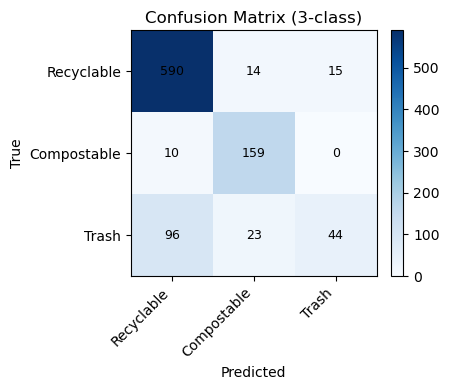

Saved confusion matrix to ../OUTPUT\confusion_matrix_3class.png


In [23]:
# --------------------------------------------------
# 8. Confusion matrix plot
# --------------------------------------------------
cm = confusion_matrix(y_test, y_pred, labels=list(range(len(COARSE_CLASSES))))

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(len(COARSE_CLASSES)))
ax.set_yticks(range(len(COARSE_CLASSES)))
ax.set_xticklabels(COARSE_CLASSES, rotation=45, ha="right")
ax.set_yticklabels(COARSE_CLASSES)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (3-class)")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()

cm_path = os.path.join(OUTPUT_DIR, "confusion_matrix_3class.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved confusion matrix to {cm_path}")